In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

ImportError: dlopen: cannot load any more object with static TLS
___________________________________________________________________________
Contents of /tmpa/tcstud25/miniconda3/lib/python3.8/site-packages/sklearn/__check_build:
__init__.py               _check_build.cpython-38-x86_64-linux-gnu.so__pycache__
setup.py
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

In [ ]:
# only the number of maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]
# drop all rows containing 0.5 to make it binary
print(len(all_data))
all_data = all_data.query('k6a1 != 0.5 & k6a2 != 0.5 & k11 != 0.5 & k12 != 0.5 & k9a1 != 0.5 & k9a2 != 0.5')
print(len(all_data))
#set the values to zero and one
#labels = ['k6a1','k6a2','k11','k12','k9a1','k9a2']
#[all_data[i].mask(all_data[i] == 0.25, 0, inplace=True) for i in labels]
#[all_data[i].mask(all_data[i] == 0.75, 1, inplace=True) for i in labels]
#print(all_data.head(10))
data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
#my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)
feature_columns_A.append(no_of_max)
k6a1 = tf.feature_column.numeric_column("k6a1")
feature_columns_A.append(k6a1)
k6a2 = tf.feature_column.numeric_column("k6a2")
feature_columns_A.append(k6a2)
k11 = tf.feature_column.numeric_column("k11")
feature_columns_A.append(k11)
k12 = tf.feature_column.numeric_column("k12")
feature_columns_A.append(k12)
k9a1 = tf.feature_column.numeric_column("k9a1")
feature_columns_A.append(k9a1)
k9a2 = tf.feature_column.numeric_column("k9a2")
feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()

In [ ]:
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=6,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    features = {name:np.array(value) for name, value in dataset.items()}
    label=dataset[label_name].to_numpy()
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
learning_rate = 1e-2
epochs = 50
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]
#label_name = "k6a1"
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="sigmoid")
epochs, hist = train_model(my_model, data_train, epochs, 
                          label_name, batch_size)
# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
features = {name:np.array(value) for name, value in data_test.items()}
label=data_test[label_name].to_numpy()
print("\n Evaluate the new model against the test set:")
evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)
predicted = my_model.predict(features)
print(predicted)
df_test=pd.DataFrame(label,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_hat"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head()

# Umbauen in ein echtes Klassifizierungsproblem

see https://sebastianraschka.com/faq/docs/softmax_regression.html

Wir haben für jede Konstante drei mögliche Werte: 0.25, 0.5 und 0.75 - das ist somit ein "ternary" (dreifaltiges?) Klassifikationsproblem. Die softmax Funktion am Ende des Modells gibt eine Wahrscheinlichkeit an, inwiefern das "feature" zu welcher Klasse gehört (prozentual). 

Ich würde mal anfangen und für k6a1 ein Modell bauen mit one-hot encoding für die drei möglichen Werte und als feature die Anzahl der Peaks. Das gleiche für ausschliesslich k6a2, k11, k12, k9a1, k9a2. Vermutlich wird das nicht so gut funktionieren weil die Information einfach nicht ausreichend ist. Da würde ich mal versuchen zu verstehen, welche Vorhersagen dir das Modell gibt, und dass du die Wahrscheinlichkeiten für die drei möglichen Klassen bekommst, für jedes Beispiel.

Im zweiten Schritt würde ich dann andere Klassen-Kombinationen probieren:
Klasse 1 - k6a1, k11, k9a1 
Klasse 2 - k6a2, k12, k9a2 

Sagen wir, die jeweiligen Werte liegen bei -1 (momentan 0.25), 0 (momentan 0.5), 1 (momentan 0.75). Die Summe aller Werte liegt damit zwischen -3 und +3.

Dann wäre Fall A: sum(Klasse 1) < -1; Fall B: -1 < sum(Klasse 1) < 1; Fall C: sum(Klasse 1) > 1. Mit den Grenzen kann man etwas herumspielen; und das gleiche jeweils für Klasse 2.

Oder vielleicht hast du noch andere Ideen.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

In [ ]:
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]

all_data=pd.get_dummies(all_data,columns=["k6a1","k6a2","k11","k12","k9a1","k9a2"])


#all_data["k6a1"]=all_data[["k6a1_0.25","k6a1_0.5","k6a1_0.75"]].values.tolist()
#all_data["k6a2"]=all_data[["k6a1_0.25","k6a1_0.5","k6a1_0.75"]].values.tolist()
#all_data["k11"]=all_data[["k11_0.25","k11_0.5","k11_0.75"]].values.tolist()
#all_data["k12"]=all_data[["k12_0.25","k12_0.5","k12_0.75"]].values.tolist()
#all_data["k9a1"]=all_data[["k9a1_0.25","k9a1_0.5","k9a1_0.75"]].values.tolist()
#all_data["k9a2"]=all_data[["k9a2_0.25","k9a2_0.5","k9a2_0.75"]].values.tolist()
#all_data=all_data.drop(columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75","k6a2_0.25","k6a2_0.5","k6a2_0.75","k11_0.25",
#                                "k11_0.5","k11_0.75","k12_0.25","k12_0.5","k12_0.75","k9a1_0.25","k9a1_0.5",
#                                "k9a1_0.75","k9a2_0.25","k9a2_0.5","k9a2_0.75"])

data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)
data_train.head()

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
#my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)
feature_columns_A.append(no_of_max)
#k6a1 = tf.feature_column.numeric_column("k6a1")
#feature_columns_A.append(k6a1)
#k6a2 = tf.feature_column.numeric_column("k6a2")
#feature_columns_A.append(k6a2)
#k11 = tf.feature_column.numeric_column("k11")
#feature_columns_A.append(k11)
#k12 = tf.feature_column.numeric_column("k12")
#feature_columns_A.append(k12)
#k9a1 = tf.feature_column.numeric_column("k9a1")
#feature_columns_A.append(k9a1)
#k9a2 = tf.feature_column.numeric_column("k9a2")
#feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)




def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=18,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)

    #for multiple inputs
    print(type(label_name))
    if(type(label_name)==list):
        label=dataset[label_name].to_numpy()
        label_array=np.zeros((label.shape[0],label.shape[1],3))
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                for k in range(len(label[i,j])):
                    label_array[i,j,k]=label[i,j][k]
            #print(label_array[i,j])
           # print(type(label_array[i,j]))
        print(label_array.shape) 
        label=label_array
    else:
        label=dataset[label_name].to_numpy()
        label_array=np.zeros((label.shape[0],3))
        for i in range(label.shape[0]):
            for k in range(len(label[i])):
                label_array[i,k]=label[i][k]
          
        print(label_array.shape) 
        label=label_array
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist


def train_model2(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)
    label=dataset[label_name].to_numpy()

    
    
    
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
learning_rate = 1e-1
epochs = 500
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

#label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]
#label_name = "k6a1"
label_name=["k6a1_0.25","k6a1_0.5","k6a1_0.75","k6a2_0.25","k6a2_0.5","k6a2_0.75","k11_0.25","k11_0.5","k11_0.75","k12_0.25","k12_0.5","k12_0.75","k9a1_0.25","k9a1_0.5","k9a1_0.75","k9a2_0.25","k9a2_0.5","k9a2_0.75"]
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="softmax")

# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 


In [ ]:
epochs, hist = train_model2(my_model, data_train, epochs, 
                          label_name, batch_size)

In [ ]:
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

if(type(label_name)==list):
    label=data_test[label_name].to_numpy()
    label_array=np.zeros((label.shape[0],label.shape[1],3))
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            for k in range(len(label[i,j])):
                label_array[i,j,k]=label[i,j][k]
        #print(label_array[i,j])
       # print(type(label_array[i,j]))
    #print(label_array.shape) 
    label=label_array
else:
    label=data_test[label_name].to_numpy()
    label_array=np.zeros((label.shape[0],3))
    for i in range(label.shape[0]):
        for k in range(len(label[i])):
            label_array[i,k]=label[i][k]

    #print(label_array.shape) 
    label=label_array


In [ ]:
features={"no_of_max":data_test["no_of_max"].to_numpy()}
label=data_test[label_name].to_numpy()
#print(label.reshape((len(label),6,3)))

print("\n Evaluate the new model against the test set:")




evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)

predicted = my_model.predict(features)

label=label.reshape((len(label),6,3))

predicted=predicted.reshape((len(predicted),6,3))
print(predicted.shape)

label_list=["k6a1","k6a2","k11","k12","k9a1","k9a2"]
for i in range(predicted.shape[0]):
    print("Test No:", i)
    for j in range(predicted.shape[1]):
        #print(1/sum(predicted[i,j]))
        print(label_list[j],"Label: ",label[i,j],"predicted: ", predicted[i,j]*1/sum(predicted[i,j]) )
print()

        
  


df_test=pd.DataFrame(label,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_0.25_label","k6a1_0.5_label","k6a1_0.75_label"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head(50)

In [5]:
#class predictions
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
#from sklearn.model_selection import train_test_split

ImportError: dlopen: cannot load any more object with static TLS
___________________________________________________________________________
Contents of /tmpa/tcstud25/miniconda3/lib/python3.8/site-packages/sklearn/__check_build:
__init__.py               _check_build.cpython-38-x86_64-linux-gnu.so__pycache__
setup.py
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

In [30]:
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]
no_data_points=(len(all_data["k6a1"].values))
#all_data=pd.get_dummies(all_data,columns=["k6a1","k6a2","k11","k12","k9a1","k9a2"])

#values between 0.75 and 2.25
#different classes:
#0 all < 0.5
#1 all > 0.5
#2 k6a1,k11,k9a1 >0.5, k6a2,k11,k9a2 <0.5
#3 k6a1,k11,k9a1 <0.5, k6a2,k11,k9a2 >0.5
#4 k6a1 == k6a2 
#5 k11 == k12 
#6 k9a1 == k9a2 
#7 sum(k6a1,k11,k9a1) < 1.25
#8 sum(k6a1,k11,k9a1) > 2
#9 sum(k6a2,k12,k9a2) < 1.25
#10 sum(k6a2,k12,k9a2) > 2

print(all_data.head())
#class_array=np.zeros((no_data_points,11))
all_data.loc[(all_data['k6a1'] <0.5) & (all_data['k6a2'] <0.5)& (all_data['k11'] <0.5)
                        & (all_data['k12'] <0.5)& (all_data['k9a1'] <0.5)&( all_data['k9a2'] <0.5), 'Class0'] = 1  
all_data.loc[(all_data['k6a1'] >0.5) & (all_data['k6a2'] >0.5)& (all_data['k11'] >0.5)
                        & (all_data['k12'] >0.5)& (all_data['k9a1'] >0.5)&( all_data['k9a2'] >0.5), 'Class1'] = 1  

all_data.loc[(all_data['k6a1'] >0.5) & (all_data['k6a2'] <0.5)& (all_data['k11'] >0.5)
                        & (all_data['k12'] <0.5)& (all_data['k9a1'] >0.5)&( all_data['k9a2'] <0.5), 'Class2'] = 1  
all_data.loc[(all_data['k6a1'] <0.5) & (all_data['k6a2'] >0.5)& (all_data['k11'] <0.5)
                        & (all_data['k12'] >0.5)& (all_data['k9a1'] <0.5)&( all_data['k9a2'] >0.5), 'Class3'] = 1  
all_data.loc[(all_data['k6a1'] == all_data['k6a2']), 'Class4'] = 1  
all_data.loc[(all_data['k11'] == all_data['k12']), 'Class5'] = 1  
all_data.loc[(all_data['k9a1'] == all_data['k9a2']), 'Class6'] = 1  
all_data.loc[((all_data['k6a1']+all_data['k11']+all_data['k9a1'])<1.25 ), 'Class7'] = 1  
all_data.loc[((all_data['k6a1']+all_data['k11']+all_data['k9a1'])>2 ), 'Class8'] = 1  
all_data.loc[((all_data['k6a2']+all_data['k12']+all_data['k9a2'])<1.25 ), 'Class9'] = 1  
all_data.loc[((all_data['k6a2']+all_data['k12']+all_data['k9a2'])>2 ), 'Class10'] = 1  








all_data=all_data.fillna(0)
data_train=all_data

#data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)
#data_train.corr()
data_train.head()

   k6a1  k6a2   k11   k12  k9a1  k9a2  no_of_max
0  0.25  0.25  0.25  0.25  0.25  0.25         18
1  0.25  0.25  0.25  0.25  0.25  0.50          5
2  0.25  0.25  0.25  0.25  0.25  0.75         19
3  0.25  0.25  0.25  0.25  0.50  0.25         19
4  0.25  0.25  0.25  0.25  0.50  0.50          5


/tmpa/tcstud25/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/tmpa/tcstud25/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/tmpa/tcstud25/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,k6a1,k6a2,k11,k12,k9a1,k9a2,no_of_max,Class0,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,0.25,0.25,0.25,0.25,0.25,0.25,18,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1,0.25,0.25,0.25,0.25,0.25,0.50,5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.25,0.25,0.25,0.25,0.25,0.75,19,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.25,0.25,0.25,0.25,0.50,0.25,19,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.25,0.25,0.25,0.25,0.50,0.50,5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [7]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
feature_columns_A.append(no_of_max)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)




def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,25,15,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=11,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model

def train_model2(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)
    label=dataset[label_name].to_numpy()

    
    
    
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [10]:
learning_rate = 1e-4
epochs = 500
batch_size = 300
print(len(data_train))
#specify the classification threshold
classification_threshold = 0.125

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

label_name=["Class0","Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10"]
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="sigmoid")

# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 


729


In [11]:
epochs_list, hist = train_model2(my_model, data_train, epochs, 
                          label_name, batch_size)

Epoch 1/500
3/3 [==============================] - 0s 10ms/step - loss: 0.4277 - accuracy: 0.7843 - precision: 0.0014 - recall: 9.9701e-04
Epoch 2/500
3/3 [==============================] - 0s 15ms/step - loss: 0.4265 - accuracy: 0.7843 - precision: 0.0014 - recall: 9.9701e-04
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 0.4256 - accuracy: 0.7843 - precision: 0.0014 - recall: 9.9701e-04
Epoch 4/500
3/3 [==============================] - 0s 7ms/step - loss: 0.4249 - accuracy: 0.7843 - precision: 0.0014 - recall: 9.9701e-04
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 0.4242 - accuracy: 0.7843 - precision: 0.0014 - recall: 9.9701e-04
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 0.4236 - accuracy: 0.7843 - precision: 0.0014 - recall: 9.9701e-04
Epoch 7/500
3/3 [==============================] - 0s 7ms/step - loss: 0.4230 - accuracy: 0.7843 - precision: 0.0014 - recall: 9.9701e-04
Epoch 8/500
3/3 [===============

3/3 [==============================] - 0s 7ms/step - loss: 0.3975 - accuracy: 0.7540 - precision: 0.1674 - recall: 0.2433
Epoch 59/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3971 - accuracy: 0.7540 - precision: 0.1674 - recall: 0.2433
Epoch 60/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3967 - accuracy: 0.7540 - precision: 0.1674 - recall: 0.2433
Epoch 61/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3962 - accuracy: 0.7540 - precision: 0.1674 - recall: 0.2433
Epoch 62/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3958 - accuracy: 0.7540 - precision: 0.1674 - recall: 0.2433
Epoch 63/500
3/3 [==============================] - 0s 10ms/step - loss: 0.3953 - accuracy: 0.7540 - precision: 0.1674 - recall: 0.2433
Epoch 64/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3949 - accuracy: 0.7540 - precision: 0.1674 - recall: 0.2433
Epoch 65/500
3/3 [==============================] - 0s 9ms/step - l

3/3 [==============================] - 0s 10ms/step - loss: 0.3736 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 119/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3732 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 120/500
3/3 [==============================] - 0s 6ms/step - loss: 0.3729 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 121/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3725 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 122/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3722 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 123/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3718 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 124/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3715 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 125/500
3/3 [==============================] - 0s 9ms/s

3/3 [==============================] - 0s 12ms/step - loss: 0.3552 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 178/500
3/3 [==============================] - 0s 10ms/step - loss: 0.3549 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 179/500
3/3 [==============================] - 0s 10ms/step - loss: 0.3546 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 180/500
3/3 [==============================] - 0s 6ms/step - loss: 0.3543 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 181/500
3/3 [==============================] - 0s 10ms/step - loss: 0.3541 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 182/500
3/3 [==============================] - 0s 11ms/step - loss: 0.3538 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 183/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3535 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 184/500
3/3 [==============================] - 0s 8

3/3 [==============================] - 0s 7ms/step - loss: 0.3404 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 237/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3402 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 238/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3400 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 239/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3398 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 240/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3396 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 241/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3393 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 242/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3391 - accuracy: 0.7237 - precision: 0.2227 - recall: 0.4855
Epoch 243/500
3/3 [==============================] - 0s 7ms/st

3/3 [==============================] - 0s 7ms/step - loss: 0.3284 - accuracy: 0.8143 - precision: 0.3333 - recall: 0.4845
Epoch 297/500
3/3 [==============================] - 0s 6ms/step - loss: 0.3282 - accuracy: 0.8143 - precision: 0.3333 - recall: 0.4845
Epoch 298/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3280 - accuracy: 0.8143 - precision: 0.3333 - recall: 0.4845
Epoch 299/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3278 - accuracy: 0.8143 - precision: 0.3333 - recall: 0.4845
Epoch 300/500
3/3 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8085 - precision: 0.3250 - recall: 0.462 - 0s 11ms/step - loss: 0.3277 - accuracy: 0.8143 - precision: 0.3333 - recall: 0.4845
Epoch 301/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3275 - accuracy: 0.8143 - precision: 0.3333 - recall: 0.4845
Epoch 302/500
3/3 [==============================] - 0s 12ms/step - loss: 0.3273 - accuracy: 0.8143 - precision: 0.

3/3 [==============================] - 0s 6ms/step - loss: 0.3189 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 356/500
3/3 [==============================] - 0s 6ms/step - loss: 0.3188 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 357/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3186 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 358/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3185 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 359/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3183 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 360/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3182 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 361/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3181 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 362/500
3/3 [==============================] - 0s 8ms/st

3/3 [==============================] - 0s 6ms/step - loss: 0.3115 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 416/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3114 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 417/500
3/3 [==============================] - 0s 5ms/step - loss: 0.3113 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 418/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3112 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 419/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3111 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 420/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3110 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 421/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3109 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 422/500
3/3 [==============================] - 0s 7ms/st

3/3 [==============================] - 0s 8ms/step - loss: 0.3060 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 476/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3060 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 477/500
3/3 [==============================] - 0s 8ms/step - loss: 0.3059 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 478/500
3/3 [==============================] - 0s 10ms/step - loss: 0.3058 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 479/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3057 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 480/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3057 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 481/500
3/3 [==============================] - 0s 7ms/step - loss: 0.3056 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
Epoch 482/500
3/3 [==============================] - 0s 9ms/s

In [13]:
features={"no_of_max":data_train["no_of_max"].to_numpy()}
label=data_train[label_name].to_numpy()
#print(label.reshape((len(label),6,3)))

print("\n Evaluate the new model against the test set:")




evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)

predicted = my_model.predict(features)

#label=label.reshape((len(label),6,3))

#predicted=predicted.reshape((len(predicted),6,3))
print(predicted.shape)


        
  


df_test=pd.DataFrame(label,columns=["0_test","1_test","2_test","3_test","4_test","5_test","6_test","7_test","8_test","9_test","10_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_0.25_label","k6a1_0.5_label","k6a1_0.75_label"])
df_predict=pd.DataFrame(predicted,columns=["Class0","Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head(50)


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 8ms/step - loss: 0.3042 - accuracy: 0.7840 - precision: 0.3333 - recall: 0.7268
(729, 11)


,0_test,1_test,2_test,3_test,4_test,5_test,6_test,7_test,8_test,9_test,...,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.021288,0.010638,0.062970,0.233646,0.191179,0.220710,0.092044,0.023819,0.100393,0.028525
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.021310,0.010642,0.062986,0.233591,0.191080,0.220800,0.092092,0.023809,0.100381,0.028513
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.021287,0.010638,0.062970,0.233640,0.191183,0.220713,0.092043,0.023818,0.100394,0.028526
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.021287,0.010638,0.062970,0.233640,0.191183,0.220713,0.092043,0.023818,0.100394,0.028526
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.021310,0.010642,0.062986,0.233591,0.191080,0.220800,0.092092,0.023809,0.100381,0.028513
5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.021287,0.010638,0.062970,0.233640,0.191183,0.220713,0.092043,0.023818,0.100394,0.028526
6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.021287,0.010638,0.062970,0.233640,0.191183,0.220713,0.092043,0.023818,0.100394,0.028526
7,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.021310,0.010642,0.062986,0.233591,0.191080,0.220800,0.092092,0.023809,0.100381,0.028513
8,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.021288,0.010638,0.062970,0.233646,0.191179,0.220710,0.092044,0.023819,0.100393,0.028525
9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.021288,0.010639,0.062970,0.233653,0.191175,0.220707,0.092045,0.023819,0.100392,0.028524


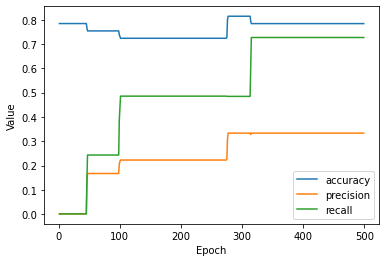

In [14]:
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs_list, hist, list_of_metrics_to_plot)

In [18]:
corr=pd.concat([df_test,df_predict], axis=1).corr()




In [27]:
import seaborn as sns
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

<AxesSubplot:>

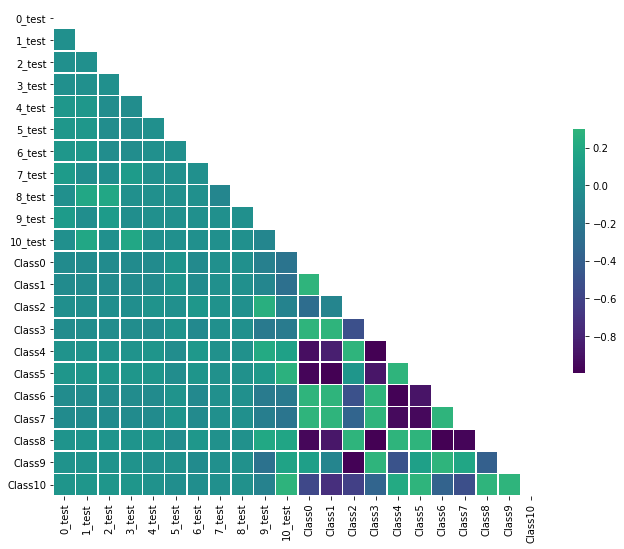

In [29]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap="viridis", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#train for each segment indepently

#values between 0.75 and 2.25
#different classes:
#category 1
#0 all < 0.5
#1 all > 0.5


#category 2
#0 all < 0.5
#1 all > 0.5
#2 k6a1,k11,k9a1 >0.5, k6a2,k12,k9a2 <0.5
#3 k6a1,k11,k9a1 <0.5, k6a2,k12,k9a2 >0.5



#category 3
#sum(k6a1,k11,k9a1) < 1.25
#sum(k6a1,k11,k9a1) > 2

#category 4
#sum(k6a2,k12,k9a2) < 1.25
#sum(k6a2,k12,k9a2) > 2